In [1]:
# !pip install loguru
# !pip install thop
# !pip install tabulate
# !pip install pycocotools

In [2]:
import cv2
from dataclasses import dataclass
import logging
import os
from pathlib import Path
from typing import List
from concurrent import futures
from concurrent.futures import ThreadPoolExecutor
import time
from PIL import Image

import numpy as np
import torch
import uuid
from yolox.exp import get_exp
from tools.aq_stereo import AqStereo
import matplotlib.pyplot as plt

log = logging.getLogger("predict")
nms = 0.4
conf = 0.6

In [3]:
@dataclass
class Item:
    id: int
    image_path: Path  # Path or S3Path
    orig_image: object
    image: object = None  # cv2 matrix? set by _load_image
    orig_shape: tuple = None  # set by _load_image
    camera: str = "unknown"  # typically left or right camera
        
class MVSBBoxProjector(object):
    def __init__(self):
        self.matcher = AqStereo()

    def compute_disparity(self, left_img, right_img):
        assert left_img.shape == right_img.shape

        if len(left_img.shape) == 3:
            left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
            right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

        left_img = left_img.astype("uint8").squeeze()
        right_img = right_img.astype("uint8").squeeze()

        disparity = self.matcher.compute(left_img, right_img)
        return disparity

    def infer_boxes_in_right(self, disparity, left_bboxes, input_res):
        return self.matcher.infer_boxes_in_right(disparity, left_bboxes, input_res)
        # NB: uses cached disparity from last call to
        # self.matcher.computeDisparity()
        
class PredictorWithMVS(object):
    # Match training input size
    img_resize_width = 416
    img_resize_height = 416

    def __init__(self, model_dir, platform, fp16_mode=True):
        self.is_local = True

        self.yolox = YOLOX_Detector.create_from_artifact_dir(
            model_dir, fp16_mode=fp16_mode, platform=platform
        )

        import pprint

        self.model_info_str = pprint.pformat(self.yolox.get_extened_exp_info())

        log.info("Load model: %s -> %s", model_dir, self.model_info_str)

        self.projector = MVSBBoxProjector()

        self.pool = ThreadPoolExecutor(max_workers=2)

        self.debug_recorder = None

        self.cnt_frames = 0

        self.model_name = "object-detection-bati"
        self.model_version = "yolox-20221207-object-detection-yolox_pytorch1.4"

        ########################################
        self.MIN_BBOX_SCORE = conf
        self.MAX_OBJECTS = (
            40  # For computation reasons we restrict maximum number of objects
        )
        self.NMS_THRESH = nms  # IOU max tolerable before considering duplicate box

    def build_result(
        self, left_id: int, right_id: int, left_bboxes: list, right_bboxes: list
    ):
        return [
            {
                "id": left_id,
                "bboxes": left_bboxes,
                "modelVersion": self.model_version,
                "modelName": self.model_name,
            },
            {
                "id": right_id,
                "bboxes": right_bboxes,
                "modelVersion": self.model_version,
                "modelName": self.model_name,
            },
        ]

    def load_items(self, file_paths, left_thumb: object, right_thumb: object):
        """ "
        From file paths and thumbnail images, construct a list of Items on which
        we can run predict on.

        Params
        ------
        :param file_paths: list of file paths to the images, used for camera lookup
        :param left_thumb: left frame thumbnail image
        :param right_thumb: right frame thumbnail image
        """
        if left_thumb is None or right_thumb is None:
            raise ValueError("Must supply left/right images")

        if len(file_paths) != 2:
            raise ValueError("Must only supply left/right file paths")

        left_path = next(fp for fp in file_paths if 'left' in str(fp))
        right_path = next(fp for fp in file_paths if 'right' in str(fp))

        imgs = [left_thumb, right_thumb]
        paths = [left_path, right_path]
        cameras = ['left', 'right']

        items = []
        for i in range(2):
            items.append(Item(
                id=i + 1,
                orig_image=imgs[i],
                image_path=paths[i],
                camera=cameras[i],
            ))

        # in-place fill in image + orig_shape fields
        load_images(items)

        return items

    def predict(self, items: List[Item], debug_mode=False, save_root=""):

        self.cnt_frames += 1

        left, right = None, None
        for item in items:
            if item.camera == "left":
                left = item
            elif item.camera == "right":
                right = item
        assert left is not None and right is not None, "Need stereo pair"

        try:
            detect_future = self.pool.submit(
                self.yolox.detect,
                img=left.image,
                orig_shape=items[0].orig_shape,
                conf_thresh=self.MIN_BBOX_SCORE,
                nms_thresh=self.NMS_THRESH,
            )
            proj_future = self.pool.submit(
                self.projector.compute_disparity, left.image, right.image
            )

            left_result = detect_future.result(timeout=1.0)
            disparity = proj_future.result(timeout=1.0)

        except futures.TimeoutError as err:
            log.error(f"YoloX or stereo computation got a timeout error; {err}")
            return self.build_result(left.id, right.id, [], [])

        l_bboxes, l_classes, l_scores = left_result
        r_bboxes, disparity_boxes = self.projector.infer_boxes_in_right(
            disparity, l_bboxes, items[0].orig_shape
        )

        right_bboxes = []
        left_bboxes = []

        def get_score_thresh():
            min_bbox_score = 0.0
            if len(l_bboxes) > self.MAX_OBJECTS:
                scores = []
                for i in range(len(l_bboxes)):
                    score = float(l_scores[i])
                    scores.append(score)
                scores.sort(reverse=True)
                min_bbox_score = scores[self.MAX_OBJECTS]
            return min_bbox_score

        bbox_score_thresh = get_score_thresh()
#         print("Score thresh;", bbox_score_thresh)

        for i in range(len(l_bboxes)):

            cls_id = int(l_classes[i])
            score = float(l_scores[i])

            if score <= bbox_score_thresh:
                continue

            pair_uuid = uuid.uuid4()
            r_box_uuid = uuid.uuid4()
            right_bboxes.append(
                {
                    "x0": int(r_bboxes[i][0]),
                    "y0": int(r_bboxes[i][1]),
                    "x1": int(r_bboxes[i][2]),
                    "y1": int(r_bboxes[i][3]),
                    "cls": cls_id,
                    "obj_conf": score,
                    "cls_conf": score,
                    "category_name": self.yolox._category_id_to_name[  # pylint: disable=W0212
                        cls_id
                    ],
                    "pair_uuid": str(pair_uuid),
                    "uuid": str(r_box_uuid),
                    "disparity": float(disparity_boxes[i]),
                }
            )

            l_box_uuid = uuid.uuid4()
            left_bboxes.append(
                {
                    "x0": int(l_bboxes[i][0]),
                    "y0": int(l_bboxes[i][1]),
                    "x1": int(l_bboxes[i][2]),
                    "y1": int(l_bboxes[i][3]),
                    "cls": cls_id,
                    "obj_conf": score,
                    "cls_conf": score,
                    "category_name": self.yolox._category_id_to_name[  # pylint: disable=W0212
                        cls_id
                    ],
                    "pair_uuid": str(pair_uuid),
                    "uuid": str(l_box_uuid),
                    "disparity": float(disparity_boxes[i]),
                }
            )

        if debug_mode:
            start = time.time()
            r = right.orig_image
            l = left.orig_image

            def create_viz(bboxes, img):
                debug = img.copy()
                for bb in bboxes:
                    x0, y0, x1, y1 = bb["x0"], bb["y0"], bb["x1"], bb["y1"]
                    cv2.rectangle(
                        debug,
                        (int(x0), int(y0)),
                        (int(x1), int(y1)),
                        [255, 255, 255],  # White
                        1,
                    )  # 1-pixel thick
                return debug

            r_viz = create_viz(right_bboxes, r)
            l_viz = create_viz(left_bboxes, l)

            disp_viz = disparity[:, :]
            disp_viz[disp_viz < 0] = 0.0
            disp_viz /= disp_viz.max() + 1e-6
            disp_viz = (255 * disp_viz).astype(np.uint8)

            disp_viz = cv2.resize(disp_viz, (r_viz.shape[1], r_viz.shape[0]))
            disp_viz = np.tile(disp_viz[:, :, None], [1, 1, r_viz.shape[-1]])

            full_viz = np.concatenate([l_viz, r_viz, disp_viz], axis=1)

            viz_fname = str(save_root) + "/debug_detector_%06d.jpg" % (self.cnt_frames)

            cv2.imwrite(viz_fname, full_viz)
            # if self.debug_recorder is None:
            #   from debug_utils import VideoRecorder
            #   self.debug_recorder = VideoRecorder(str(save_root)+'/debug_detector.mp4')

            # self.debug_recorder.append_data(full_viz)
            print("debug viz time", time.time() - start)

        return self.build_result(left.id, right.id, left_bboxes, right_bboxes)

    def __repr__(self):
        return f"PredictorWithMVS('{self.model_info_str}')"
    
class YOLOX_Detector(object):
    """If platfrom not "cpu" or "gpu" will Wraps a TensorRT engine instance and
     provides basic inference functionality for YoloX.

    Based upon MFT-PG YOLOX_TRT_Detector:
    https://github.com/aquabyte-new/research-exploration/blob/d4cdafa4d9e758c7d06c1a30676a6cbb0b97e082/pwais/mft-pg/mft_utils/detection_inference.py#L222

    NOTE: This detector might fail to garbage collect due to pytorch.
    For extended inference, you may need to structure your input using
    a pytorch dataset.
    """

    @classmethod
    def create_from_artifact_dir(
        cls, artifact_dir, fp16_mode=True, platform="NVIDIA.Tegra.X2"
    ):
        # Based upon https://github.com/Megvii-BaseDetection/YOLOX/blob/69f1173a569f1e0cc41025146a32b5d5fa06dd26/tools/demo.py#L235

        print("Platform specified;", platform)

        pth_engine_path = maybe_lazy_create_engine(
            artifact_dir, fp16_mode=fp16_mode, platform=platform
        )
        log.info("Using this engine %s", pth_engine_path)

        exp_file = os.path.join(artifact_dir, "mft_pg_yolox_exp.py")

        from yolox.exp import get_exp

        exp = get_exp(exp_file, None)

        model = exp.get_model()
        if "cpu" not in platform:
            model = model.cuda()

        from yolox.utils.model_utils import get_model_info

        log.info("Inferecing for model size %s", get_model_info(model, exp.test_size))
        model.head.decode_in_inference = False
        model.eval()

        decoder = model.head.decode_outputs

        x = torch.ones(1, 3, exp.test_size[0], exp.test_size[1])

        if "cpu" in platform or "gpu" in platform:
            log.info("Using cpu or regular Non-TensorRT gpu")
            print(pth_engine_path)

            ckpt = torch.load(pth_engine_path, map_location="cpu")

            model.load_state_dict(ckpt["model"])

            if "gpu" in platform:
                log.info("Using regular non-TensorRT gpu; platform")
                model = model.cuda()

            model(x)

        else:
            log.info("Using tensorrt")

            from torch2trt import TRTModule  # pylint: disable=E0401

            model_trt = TRTModule()
            model_trt.load_state_dict(torch.load(pth_engine_path))
            x = x.cuda()
            model(x)
            # warm the model & torch cache
            # this also lazily instantiates the decoder ...
            model = model_trt

        h, w = exp.test_size

        import json

        raw_category_id_to_name = json.loads(exp.category_id_to_name_json)
        category_id_to_name = dict(
            (int(k), v) for k, v in raw_category_id_to_name.items()
        )

        return cls(
            model, platform, decoder, exp, (h, w), category_id_to_name, fp16=fp16_mode
        )

    def __init__(
        self, model, platform, decoder, exp, input_hw, category_id_to_name, fp16=True
    ):
        self._model = model
        self._platform = platform
        self._decoder = decoder
        self._exp = exp
        self._input_hw = (input_hw[0], input_hw[1])
        self._category_id_to_name = category_id_to_name
        self._fp16 = fp16

        from yolox.data.data_augment import ValTransform

        self._preproc = ValTransform()

        from yolox.utils import postprocess

        self._postprocess = postprocess

    def get_extened_exp_info(self):
        KEYS = (
            "depth",
            "width",
            "nmsthre",
        )
        return dict((k, getattr(self._exp, k)) for k in KEYS)

    def detect(
        self, img_path="", img=None, orig_shape=None, conf_thresh=0.6, nms_thresh=0.4
    ):

        if img is None:
            assert os.path.exists(img_path)  # cv2 fails silently on file no existe
            img = cv2.imread(img)  # YOLOX assumes cv2 reader in preproc

#         print(conf_thresh)
#         print(nms_thresh)
        cur_shape = img.shape
        ratio_x = orig_shape[1] / cur_shape[1]
        ratio_y = orig_shape[0] / cur_shape[0]

        img, _ = self._preproc(img, None, self._input_hw)
        # NB: This also scales image values...
        # https://github.com/Megvii-BaseDetection/YOLOX/blob/69f1173a569f1e0cc41025146a32b5d5fa06dd26/yolox/data/data_augment.py#L153

        assert self._model is not None

        img = torch.from_numpy(img).unsqueeze(0)
        if "cpu" not in self._platform:
            img = img.cuda()

        if self._fp16:
            img = img.half()

        outputs = self._model(img)
        outputs = self._decoder(outputs, dtype=outputs.type())
        outputs = outputs.float().cpu()

        try:
            outputs = self._postprocess(
                outputs,
                len(self._category_id_to_name),
                conf_thre=conf_thresh,
                nms_thre=nms_thresh,
                class_agnostic=True,
            )  # we want to throw out overlapping boxes even if different classes
        except IndexError as err:
            log.error(f"YoloX detector postprocess got an index error; {err}")
            return []

        output = outputs[0]
        if output is None:
            output = np.zeros((0, 7))
        else:
            output = output.cpu().detach().numpy()

        bboxes = output[:, 0:4]
        classes = output[:, 6]
        scores = output[:, 4] * output[:, 5]

        # NB For more on data schema see:
        # https://github.com/Megvii-BaseDetection/YOLOX/blob/69f1173a569f1e0cc41025146a32b5d5fa06dd26/yolox/utils/visualize.py#L11
        bboxes[:, 0] *= ratio_x
        bboxes[:, 1] *= ratio_y
        bboxes[:, 2] *= ratio_x
        bboxes[:, 3] *= ratio_y

        return (bboxes, classes, scores)
    
def maybe_lazy_create_engine(artifact_dir, fp16_mode=True, platform="NVIDIA.Tegra.X2"):

    if fp16_mode:
        platform = platform + ".fp16"
    pth_engine_path = os.path.join(artifact_dir, "yolox.%s.pth" % platform)
    if not os.path.exists(pth_engine_path):

        log.info("****************************************************************")
        log.info("****************************************************************")
        log.info(f"Cannot find TRT engine for {platform}, trying to create one ...")

        pth_engine_path = create_engine(
            yolox_artifacts_base_dir=artifact_dir,
            outdir=artifact_dir,  # Create in-place!
            fp16_mode=fp16_mode,
            platform=platform,
        )

        if "cpu" not in platform:
            torch.cuda.empty_cache()
            # (try to) release temporaries used from loading checkpoint

        log.info(f"... saved engine to {pth_engine_path}")
        log.info("****************************************************************")
        log.info("****************************************************************")

    return pth_engine_path

def load_images(items: List[Item]):
    # load item.image inplace
    for item in items:
        image = item.orig_image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        item.orig_shape = image.shape
        item.image = cv2.resize(
            image,
            (PredictorWithMVS.img_resize_width, PredictorWithMVS.img_resize_height),
        )
        
def load_img(path):
    return cv2.imdecode(
        np.frombuffer(path.read_bytes(), np.uint8),
        cv2.IMREAD_COLOR,
    )

In [4]:
model = PredictorWithMVS(
    model_dir="./",
    platform="cpu",
    fp16_mode=False,
)

# print(model)

Platform specified; cpu
./yolox.cpu.pth


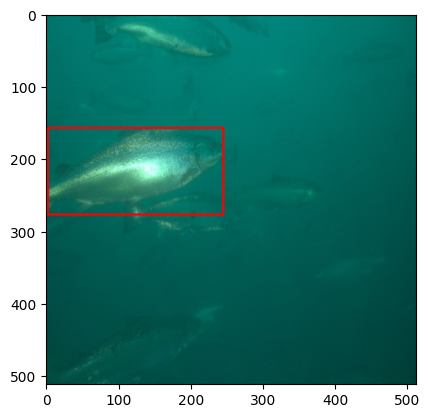

In [5]:
left_frame = Path("assets/01.jpg")
right_frame = Path("assets/02.jpg")

left_img = load_img(left_frame)
right_img = load_img(right_frame)


left = Item(id=1, image_path="fake-path-1", orig_image=left_img, camera="left")
right = Item(id=2, image_path="fake-path-2", orig_image=right_img, camera="right")

# in place
items = [left, right]
load_images(items)
img_lookup = {i.id: i.orig_image for i in items}
results = model.predict(items)

im=cv2.imread('assets/01.jpg')
im=cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

for box in results[0]['bboxes']:
    cv2.rectangle(im, (box['x0'], box['y0']), (box['x1'], box['y1']), (255, 0, 0), 2)
    
plt.imshow(im)    